In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *
from scipy.sparse.linalg import gmres, LinearOperator
from util.unet import *

### Beating GMRES on a well-conditioned system - Is it possible?
In this short project we examine the possibility to accelerate the mapping from boundary data to boundary conditions using deep learning. Given boundary data $u \colon \partial\Omega \to \mathbb{R}$ of a region $\Omega$ of Euclidean space $\mathbb{R}^d$ whose boundary is parameterised by some $\gamma \colon [0,2\pi] \to \mathbb{R}^d$, the density $\rho$ is obtained as

\begin{equation}
 \mathcal{A}_\gamma \rho = u
\end{equation}

where the operator $\mathcal{A}_\gamma$ is parameterised by $\gamma$. Without getting to caught up in the details, GMRES takes the iterative form

\begin{equation}
     \rho_{n} = step(\mathcal{A}_\gamma, \rho_{m<n}),\qquad \rho_0 = u.
\end{equation}

Due to well-posedness of $\mathcal{A}_\gamma$, the number of iterations required is low for smooth systems. In such cases, the number of iterations required for machine precision is on the scale of 10-20. However, when introducing corners into the geometry, it becomes harder to obtain good convergence. Furthermore, preconditioners can be expensive so if the corner geometry is unpredictable (i.e. the angle of the corner), this solution needs improvement. 


#### Learning $\mathcal{A}_\gamma^{-1}$

We define a data point as an array containing the Fourier coefficients for the boundary and boundary condition. This is contained in the `ProblemData` class along with some help functions. The function `ProblemData.random_problemdata()` can be used to sample a data point with a fixed number of coefficients. Given some number $K$, the Fourier coefficients $c_k\in \mathbb{C}$ are generated using samples $c$ from a $\mathcal{N}(0,\sigma)$ distributed variable:

\begin{equation}
    c_k = 
    \begin{cases}
    0, & \text{if} \quad k=-1,0\\
    1, & \text{if} \quad k=1\\
    c e^{-d|k|}, &\text{otherwise}
    \end{cases}
\end{equation}

Here, $d,\sigma$ are hyper parameters, called `decay` and `amplitude` in the code. The data can be converted to a dirichlet problem using `ProblemData.to_problem()`. However, for the resulting problem to be well-posed, two conditions must be satisfied: The boundary should not intersect itself, and the dirichlet velocity should integrate to zero along the boundary. These two conditions can be enforced by passing the variables `allow_intersections` and `allow_net_flow` to the `random_problemdata()` function. These are implemented in different ways.

* The self intersections are eliminated by applying rejection sampling: 
    1. Sample $c_k$, check for intersections.
    2. If no intersections are found, $c_k$ is accepted. 
    3. If an intersection is found, repeat from step 1.
    
    
* The net flow is eliminated by introducing a correction $\delta_k$ to the Fourier coefficients,
  that satisfy
     \begin{equation}
           \min_{\delta_k} \sum_{k=-K}^K (1+|k|)^\alpha||\delta_k||^2, \quad \text{subject to zero net flow.}
     \end{equation}
   Here, $\alpha$ is a parameter that if high, dampens high frequency corrections to the field.
   


problem 0, solve finished in 12 iterations
problem 1, solve finished in 12 iterations
problem 2, solve finished in 14 iterations
problem 3, solve finished in 14 iterations
problem 4, solve finished in 13 iterations
problem 5, solve finished in 12 iterations
problem 6, solve finished in 13 iterations
problem 7, solve finished in 14 iterations
problem 8, solve finished in 12 iterations
problem 9, solve finished in 14 iterations
problem 10, solve finished in 13 iterations
problem 11, solve finished in 13 iterations
problem 12, solve finished in 12 iterations
problem 13, solve finished in 13 iterations
problem 14, solve finished in 13 iterations
problem 15, solve finished in 12 iterations


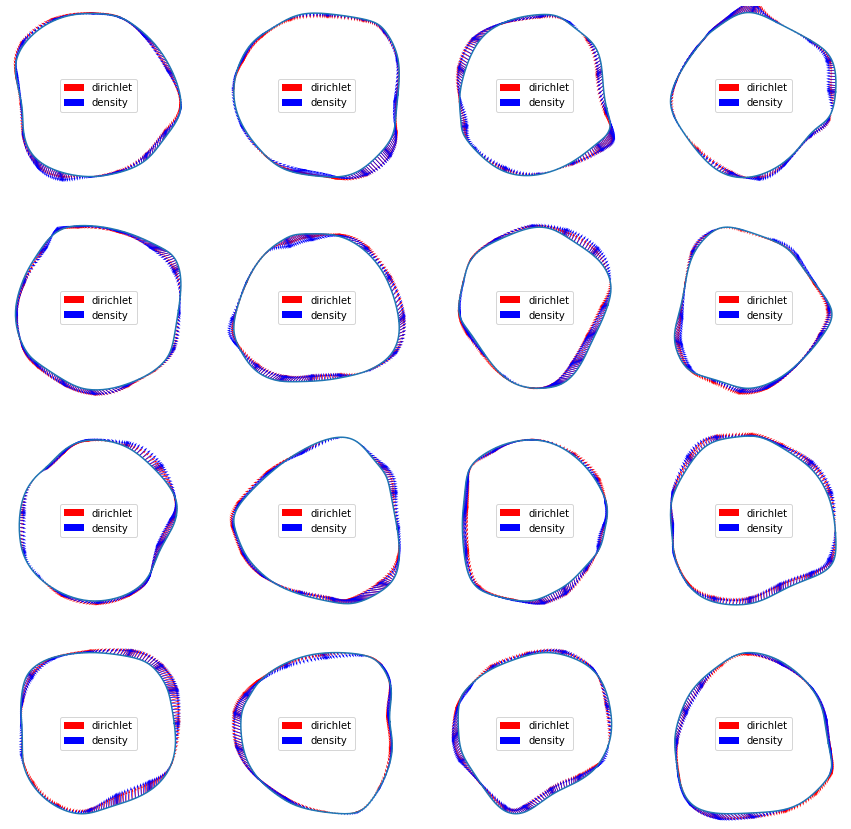

In [2]:
np.random.seed(0)
# Create simple counting callback
class Callback:
    def __init__(self):
        self.counter = 0
        
    def __call__(self, args):
        self.counter += 1
        
    def reset(self):
        self.counter = 0
callback = Callback()

# Generate some data
data = []
sols = []
corrs = []
n = 4
plt.figure(figsize=(15,15))
for i in range(n*n):
    callback.reset()
    
    # Generate data
    data.append(ProblemData.random_problemdata(K=20, 
                                               bound_amplitude=0.1,
                                               bound_decay=0.5, 
                                               cond_amplitude=0.5,
                                               cond_decay=0.4,
                                               allow_intersections=False, 
                                               allow_net_flow=False,
                                               decay_type="exp",
                                               refine=4,
                                               tol=1e-13))
                                               #allow_intersections=(i >= n*n//2), tol=1e-10))
    # Solve
    problem = data[-1].to_problem(n=4)
    problem.solve(callback=callback, tol=1e-13)
    sols.append(problem)
    
    # Plot data
    plt.subplot(n,n,i+1)
    problem.plot(ax=plt.gca())
    plt.axis("equal")
    plt.legend()
    remove_axes(plt.gca())
    
    pts = problem.geometry.self_intersections(tol = 1e-13)
    plt.scatter([np.real(z) for z in pts], [np.imag(z) for z in pts], 
                s=100, color='black', marker='x',zorder=3, linewidth=5)
    print(f"problem {i}, solve finished in {callback.counter} iterations")

We can look at these mappings as a function of the boundary parameter to get an understanding of the mapping from boundary and dirichlet conditions to the density.

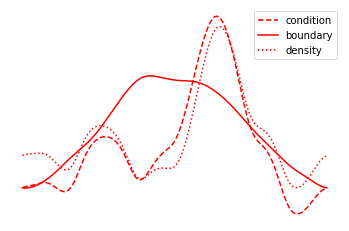

In [7]:
sol = sols[0]
coefs = sol.fourier_density(K=20)

t, _ = sol.geometry.grid.get_grid_and_weights()
condition = sol.condition(t)
boundary = sol.geometry.eval_param(derivative=0)

#plt.plot(t,  np.real(condition),'b--')
plt.plot(t, -np.imag(condition),'r--', label='condition')

plt.plot(t, -np.real(boundary),'r', label='boundary')
#plt.plot(t, -np.imag(boundary),'b')

plt.plot(t, np.real(sol.density),'r:', label='density')
#plt.plot(t, np.imag(sol.density),'b:')

remove_axes(plt.gca())
plt.legend()

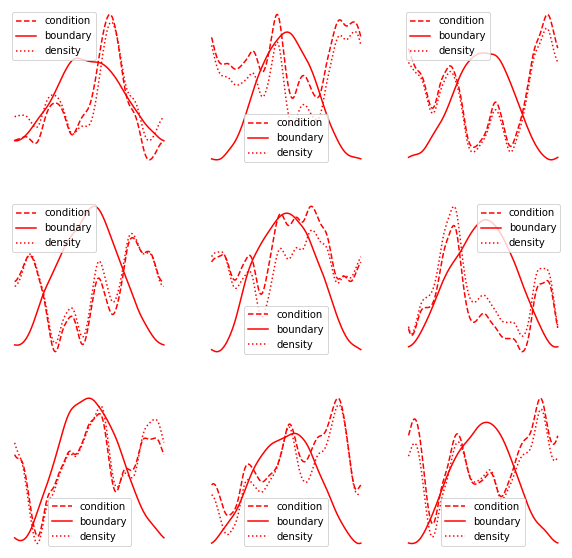

In [11]:
m = 3
plt.figure(figsize=(10,10))
for i in range(m*m):
    sol = sols[i]
    plt.subplot(m,m,i+1)
    coefs = sol.fourier_density(K=20)
    t, _ = sol.geometry.grid.get_grid_and_weights()
    condition = sol.condition(t)
    boundary = sol.geometry.eval_param(derivative=0)
    
    #plt.plot(t,  np.real(condition),'b--')
    plt.plot(t, -np.imag(condition),'r--', label='condition')
    
    plt.plot(t, -np.real(boundary),'r', label='boundary')
    #plt.plot(t, -np.imag(boundary),'b')
    
    plt.plot(t, np.real(sol.density),'r:', label='density')
    #plt.plot(t, np.imag(sol.density),'b:')
    
    remove_axes(plt.gca())
    plt.legend()
    

Here's a closer look at the corresponding solutions to the stokes problems.

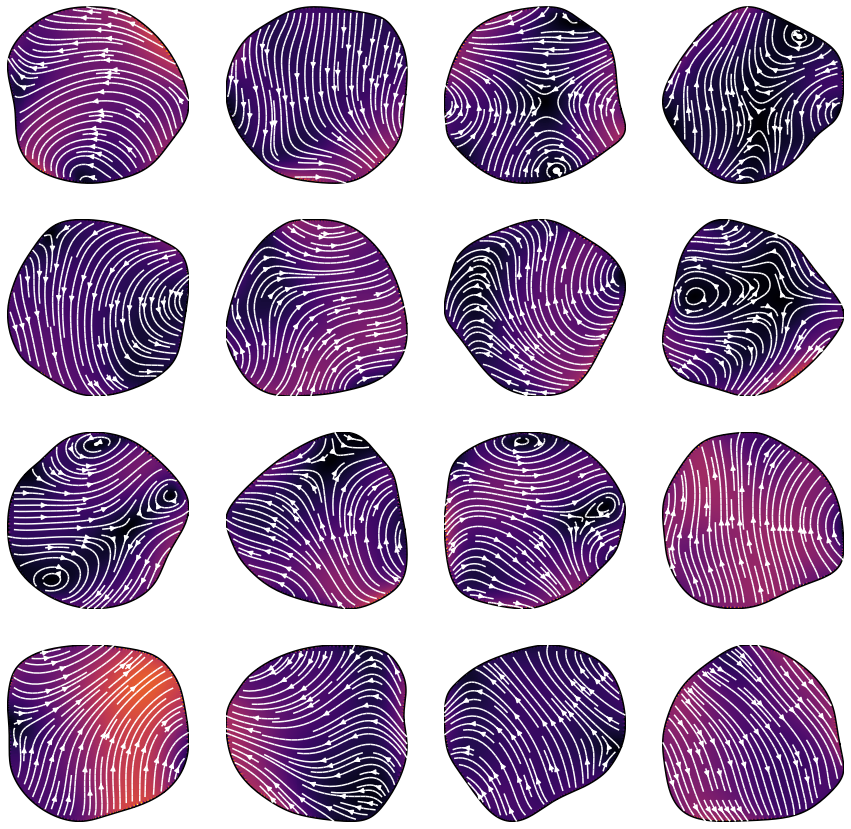

In [6]:
plt.figure(figsize=(15,15))
for i, sol in enumerate(sols):
    plt.subplot(n,n,i+1)
    def speed(z):
        vel = sol.evaluate(z)
        return np.abs(vel)
    sol.geometry.plot(ax=plt.gca(), color='black')
    sol.geometry.plot_field(ax=plt.gca(), func=speed, apply_mask=True, vmin=0, vmax=4, cmap="inferno")
    sol.geometry.plot_stream(ax=plt.gca(), func=sol.evaluate, apply_mask=True, color='white')
    remove_axes(plt.gca())

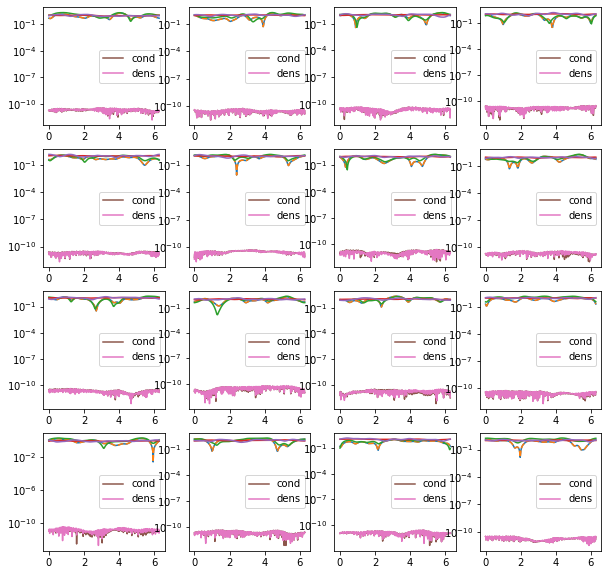

In [5]:
plt.figure(figsize=(10,10))
for i,sol in enumerate(sols):
    t, _ = sol.geometry.grid.get_grid_and_weights()
    
    dens = sol.density
    dens_2 = sol.inv_fourier_tfm(sol.fourier_tfm(lambda t: dens, 60), 60)
    dens_2 = dens_2(t)
    
    cond = sol.inv_fourier_tfm(sol.fourier_tfm(sol.condition, 60), 60)
    cond = cond(t)
    
    plt.subplot(n,n,i+1)
    #plt.plot(t, np.imag(dens))
    #plt.plot(t, np.imag(dens_2))
    #remove_axes(plt.gca())
    plt.plot(t, np.abs(dens))
    plt.plot(t, np.abs(dens_2), '--')
    
    plt.plot(t, np.abs(sol.condition(t)))
    plt.plot(t, np.abs(sol.geometry.param[0](t)))
    plt.plot(t, np.abs(sol.geometry.param[1](t)))
    
    plt.plot(t, np.abs(cond - sol.condition(t)), label='cond')
    plt.plot(t, np.abs(dens - dens_2), label='dens')
    
    plt.yscale("log")
    
    plt.legend()
    

## Generate and save the data into a big file.

In [8]:
# Create simple counting callback
class Callback:
    def __init__(self, printer):
        self.counter = 0
        self.printer = printer
        
    def __call__(self, args=None):
        self.counter += 1
        self.printer(self)
        
    def reset(self):
        self.counter = 0

N = 10

# Number of modes for in data 
K_in = 20
Kbig_in = 2*K_in + 1

# Number of modes for out data
K_out = 60
Kbig_out = 2*K_out + 1

# Allocate spac
in_data = torch.zeros(N, 4, Kbig_in) # Input data (real, imag) x (bound, condition)
out_data = torch.zeros(N, 2, Kbig_out) # Output (real, imag) x density

for i in range(N):
    callback = Callback(printer=lambda cb: 
                        print(f"Generating datapoint {i+1}/{N}. No resamples = {cb.counter}", end="\n"))
    
    data = ProblemData.random_problemdata(K=K_in, 
                                          bound_amplitude=0.1,
                                          bound_decay=0.5, 
                                          cond_amplitude=0.5,
                                          cond_decay=0.4,
                                          allow_intersections=False, 
                                          allow_net_flow=False,
                                          decay_type="exp",
                                          refine=4,
                                          callback=callback,
                                          tol=1e-13)
                                          #allow_intersections=(i >= n*n//2), tol=1e-10))
    print(f"Generating datapoint {i+1}/{N}. Solving system for density", end="\n")
    # Solve
    data.set_density(n=4, tol=1e-13, K_density=K_out, maxiter=20)
    
    print(f"Generating datapoint {i+1}/{N}. Setting data.", end="\n")
    # Set in data
    in_data[i, 0, :] = torch.from_numpy(np.real(data.bound_coef))
    in_data[i, 1, :] = torch.from_numpy(np.imag(data.bound_coef))
    in_data[i, 2, :] = torch.from_numpy(np.real(data.u_coef))
    in_data[i, 3, :] = torch.from_numpy(np.imag(data.u_coef))
    
    # set out data
    out_data[i, 0, :] = torch.from_numpy(np.real(data.density_coef))
    out_data[i, 1, :] = torch.from_numpy(np.imag(data.density_coef))
    

# Save data to file
data = {"X": in_data, "Y": out_data}
torch.save(data, "/home/emastr/phd/data/problem_data_TEST.torch")

Generating datapoint 1/10. No resamples = 1
Generating datapoint 1/10. Solving system for density
Generating datapoint 1/10. Setting data.
Generating datapoint 2/10. No resamples = 1
Generating datapoint 2/10. Solving system for density
Generating datapoint 2/10. Setting data.
Generating datapoint 3/10. No resamples = 1
Generating datapoint 3/10. Solving system for density
Generating datapoint 3/10. Setting data.
Generating datapoint 4/10. No resamples = 1
Generating datapoint 4/10. Solving system for density
Generating datapoint 4/10. Setting data.
Generating datapoint 5/10. No resamples = 1
Generating datapoint 5/10. Solving system for density
Generating datapoint 5/10. Setting data.
Generating datapoint 6/10. No resamples = 1
Generating datapoint 6/10. Solving system for density
Generating datapoint 6/10. Setting data.
Generating datapoint 7/10. No resamples = 1
Generating datapoint 7/10. Solving system for density
Generating datapoint 7/10. Setting data.
Generating datapoint 8/10. 